In [6]:
import pandas as pd
import numpy as np
import streamlit as st
from scipy import stats
from dateutil.relativedelta import relativedelta
from PIL import Image
from scipy.stats import wilcoxon

# <데이터 불러오기>

data = pd.read_csv('biz_data.csv', low_memory = False, dtype ={'사업시작월':str, '참가기업사업자번호':str})
exp_df = pd.read_csv('expamt_data.csv', low_memory = False, dtype ={'BSNO':str})
rec_df = pd.read_csv('biz_rec_30.csv', dtype ={'사업시작월':str, '참가기업사업자번호':str})

In [10]:
# 월, 기간 입력 시 비교기간전 시작월, 마지막월 / 비교기간 후 시작월, 마지막월 도출함수

def make_basis_months(mon, basis = 12):
    mon_base = pd.to_datetime(mon+'01')
    mon_delta = relativedelta(months = basis)
   
    # 사업참가전 시작 년, 월 반환
    pre_str_mon = mon_base - mon_delta  
    pre_str_year =  str(pre_str_mon.year)
    pre_str_month  = pre_str_mon.month
    if len(str(pre_str_month)) == 1:
        pre_str_month = '0' + str(pre_str_month)
    else:
        pre_str_month = str(pre_str_month)
    pre_str_mon =  pre_str_year + pre_str_month
    
    # 사업참가전 종료 년, 월 반환
    pre_end_mon = mon_base - relativedelta(months=1)
    pre_end_year = str(pre_end_mon.year)
    pre_end_month =  pre_end_mon.month
    if len(str(pre_end_month)) ==1:
        pre_end_month = '0' + str(pre_end_month)
    else:
        pre_end_month = str(pre_end_month)    
    pre_end_mon = pre_end_year + pre_end_month
    
     # 사업참가후 시작 년, 월 반환
    post_str_mon = mon_base + relativedelta(months=1)  
    post_str_year =  str(post_str_mon.year)
    post_str_month =  post_str_mon.month
    if len(str(post_str_month)) ==1:
        post_str_month = '0' + str(post_str_month)
    else:
        post_str_month = str(post_str_month)
    post_str_mon =  post_str_year + post_str_month
    
    # 사업참가후 시작 년, 월 반환
    post_end_mon = mon_base + mon_delta  
    post_end_year =  str(post_end_mon.year)
    post_end_month =  post_end_mon.month
    if len(str(post_end_month)) ==1:
        post_end_month = '0' + str(post_end_month)
    else:
        post_end_month = str(post_end_month)
    post_end_mon =  post_end_year + post_end_month
    
    
    return pre_str_mon, pre_end_mon, post_str_mon, post_end_mon
    

In [11]:
# 사업실적 평가함수

def eval_kotra_biz_re(biz_name, basis_month, period):
    
    pre_str_mon, pre_end_mon, post_str_mon, post_end_mon = make_basis_months(basis_month, period)
    
    idx = data[(data['사업명'] == biz_name) & (data['사업시작월'] == basis_month)]['참가기업사업자번호'].unique().tolist()
    result_df = exp_df[exp_df['BSNO'].isin(idx)]
    result_df.set_index('BSNO', inplace = True)
    pre = result_df.loc[:,  pre_str_mon:pre_end_mon].mean(axis =1)
    post = result_df.loc[:, post_str_mon:post_end_mon].mean(axis =1)
    diff = post.mean() - pre.mean()
    t, p_value = stats.ttest_rel(pre, post)
    num_company = len(result_df)
    
    return num_company, pre_str_mon, pre_end_mon, pre.mean(), post_str_mon, post_end_mon, post.mean(), diff, p_value
    
    

In [55]:
def eval_kotra_wilcoxon(biz_name, basis_month, period):
    
    pre_str_mon, pre_end_mon, post_str_mon, post_end_mon = make_basis_months(basis_month, period)
    
    idx = data[(data['사업명'] == biz_name) & (data['사업시작월'] == basis_month)]['참가기업사업자번호'].unique().tolist()
    result_df = exp_df[exp_df['BSNO'].isin(idx)]
    result_df.set_index('BSNO', inplace = True)
    pre = result_df.loc[:,  pre_str_mon:pre_end_mon].mean(axis =1)
    post = result_df.loc[:, post_str_mon:post_end_mon].mean(axis =1)
    diff = post - pre
    diff_amt = post.mean() - pre.mean()
    s, p_value = stats.wilcoxon(diff, alternative = 'greater')
    num_company = len(result_df)
    
    print("사업명: {}, 사업시작월: {}".format(biz_name, basis_month))
    print('사업참가기업수: {} 개사'.format(len(result_df)))
    print()
    print('사업참가 전 12개월 기업별 월평균수출금액의 평균: $ {:.2f}'.format(pre.mean()))
    print('사업참가 후 12개월 기업별 월평균수출금액의 평균: $ {:.2f}'.format(post.mean())) 
    print('사업참가 전후 월평균수출금액차이: $ {:.2f}'.format(diff_amt))
    print()
      
    w, p_value = stats.wilcoxon(diff, alternative = 'greater')
    
    print('해당사업의 Wilcoxon 순위합 검정의 p-value: {:.4f}'.format(p_value))
    
    if p_value <= 0.05:
        print('해당사업은 통계적으로 유효성이 입증됩니다.')
        print()
        print('{} 에 시작한 {} 의 1년간 총효과는 $ {:.0f} 로 추정됩니다.'.format(basis_month, biz_name, diff_amt*12*447))
    else:
        print('해당사업은 통계적으로 유효성이 입증되지 않습니다.')
    
    

In [62]:
# 사업 샘플데이터 보여주는 함수

def show_biz_sample(biz_name):
    df = rec_df[rec_df['사업명'].str.contains(biz_name)]
    df = df[df['사업시작월'].str.contains('2019|2020|2021|2022')]
    df = df[['사업명', '사업시작월']].reset_index().drop('index', axis = 1)
    # if len(df) > 7:
    #    df = df.head(7)
    return df 

In [23]:
rec_df.head()

,사업구분,사업명,사업시작월,참가기업사업자번호
0,수출상담회,2022 바이코리아센터 상시 화상상담회(연중),202201,7187
1,신규수출기업화,신규수출화사업,202101,5606
2,기타사업,2021 중국 서북부지역 내륙 미개척시장 진출 지원사업,202103,5026
3,신규수출기업화,신규 수출기업화 사업,202201,4935
4,전시회,2020년도 KOTRA 해외전시회 개별참가 지원사업,202001,3018


In [61]:
show_biz_sample('연중')

,사업명,사업시작월
0,2022 바이코리아센터 상시 화상상담회(연중),202201
1,중국 코로나19 재확산 대응 연중 화상상담 사업,202201
2,중국 코로나19 재확산 대응 연중 화상상담 사업(하얼빈),202201
3,중국 코로나19 재확산 대응 연중 화상상담 사업(베이징),202201
4,중국 코로나19 재확산 대응 연중 화상상담 사업(상하이),202201
5,중국 코로나19 재확산 대응 연중 화상상담 사업(광저우),202201
6,중국 코로나19 재확산 대응 연중 화상상담 사업(충칭),202201
7,중국 코로나19 재확산 대응 연중 화상상담 사업(선전),202201
8,중국 코로나19 재확산 대응 연중 화상상담 사업(샤먼),202201


In [56]:
eval_kotra_wilcoxon('[유통중점][실리콘밸리]2021 해외유통망 협력사업', '202102', 12)

사업명: [유통중점][실리콘밸리]2021 해외유통망 협력사업, 사업시작월: 202102
사업참가기업수: 97 개사

사업참가 전 12개월 기업별 월평균수출금액의 평균: $ 10485.93
사업참가 후 12개월 기업별 월평균수출금액의 평균: $ 18280.54
사업참가 전후 월평균수출금액차이: $ 7794.61

해당사업의 Wilcoxon 순위합 검정의 p-value: 0.0000
해당사업은 통계적으로 유효성이 입증됩니다.

202102 에 시작한 [유통중점][실리콘밸리]2021 해외유통망 협력사업 의 1년간 총효과는 $ 41810306 로 추정됩니다.


In [58]:
eval_kotra_wilcoxon('북미 온라인 한국우수상품전(실리콘밸리)', '202009', 12)

사업명: 북미 온라인 한국우수상품전(실리콘밸리), 사업시작월: 202009
사업참가기업수: 33 개사

사업참가 전 12개월 기업별 월평균수출금액의 평균: $ 139688.34
사업참가 후 12개월 기업별 월평균수출금액의 평균: $ 480597.44
사업참가 전후 월평균수출금액차이: $ 340909.10

해당사업의 Wilcoxon 순위합 검정의 p-value: 0.0099
해당사업은 통계적으로 유효성이 입증됩니다.

202009 에 시작한 북미 온라인 한국우수상품전(실리콘밸리) 의 1년간 총효과는 $ 1828636431 로 추정됩니다.


In [14]:
eval_kotra_biz_re('지사화사업', '201808', 12)

(735,
 '201708',
 '201807',
 590356.1352607709,
 '201809',
 '201908',
 607567.3173469388,
 17211.182086167857,
 0.23174981102270914)

In [32]:
# 사전값, 사후값 분포를 보기 위한 방법

def check_distribute(biz_name, basis_month, period):
    
    pre_str_mon, pre_end_mon, post_str_mon, post_end_mon = make_basis_months(basis_month, period)
    
    idx = data[(data['사업명'] == biz_name) & (data['사업시작월'] == basis_month)]['참가기업사업자번호'].unique().tolist()
    result_df = exp_df[exp_df['BSNO'].isin(idx)]
    result_df.set_index('BSNO', inplace = True)
    pre = result_df.loc[:,  pre_str_mon:pre_end_mon].mean(axis =1)
    post = result_df.loc[:, post_str_mon:post_end_mon].mean(axis =1)
    value = post - pre
    return value
    

In [35]:
diff = check_distribute('지사화사업', '201808', 12)

In [63]:
diff

BSNO
1018151010   -22913.583333
1018670725     2518.500000
1028207208        0.000000
1048157634   -96535.666667
1051621505        0.000000
                  ...     
8398700374    93639.166667
8428700462    -3000.000000
8448700978        0.000000
8938600425      130.000000
8958100881     2159.666667
Length: 735, dtype: float64

In [65]:
from scipy.stats import shapiro

In [41]:
s, p_value = wilcoxon(diff, alternative = 'greater')

WilcoxonResult(statistic=141386.5, pvalue=0.0021976975573224436)

In [67]:
shapiro(diff)  # 정규성 검정을 충족하지 못함..

ShapiroResult(statistic=0.36520713567733765, pvalue=1.2611686178923354e-44)

In [71]:
import matplotlib.pyplot as plt

(array([ 27.,   3.,   8.,  23.,  56.,  62., 119.,  86.,  32.,   5.]),
 array([ 0.        ,  1.57487328,  3.14974655,  4.72461983,  6.2994931 ,
         7.87436638,  9.44923965, 11.02411293, 12.59898621, 14.17385948,
        15.74873276]),
 <BarContainer object of 10 artists>)

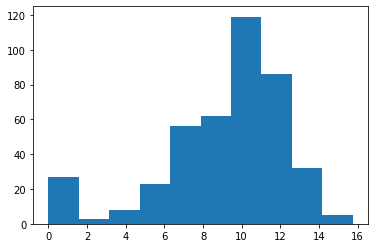

In [73]:
plt.hist(np.log1p(diff))

In [86]:
shapiro(np.log1p(diff).reset_index()[np.log1p(diff).reset_index()[0].notnull()][0])

# NAN을 제거 하려면??



ShapiroResult(statistic=0.891350507736206, pvalue=1.0659495389144603e-16)

In [74]:
shapiro(np.log1p(diff)) # 로그변환하더라도 diff 가 정규분포를 따른다고 볼 수 없음..

ShapiroResult(statistic=nan, pvalue=1.0)

In [39]:
?wilcoxon

Signature:
wilcoxon(
    x,
    y=None,
    zero_method='wilcox',
    correction=False,
    alternative='two-sided',
    mode='auto',
)
Docstring:
Calculate the Wilcoxon signed-rank test.

The Wilcoxon signed-rank test tests the null hypothesis that two
related paired samples come from the same distribution. In particular,
it tests whether the distribution of the differences x - y is symmetric
about zero. It is a non-parametric version of the paired T-test.

Parameters
----------
x : array_like
    Either the first set of measurements (in which case `y` is the second
    set of measurements), or the differences between two sets of
    measurements (in which case `y` is not to be specified.)  Must be
    one-dimensional.
y : array_like, optional
    Either the second set of measurements (if `x` is the first set of
    measurements), or not specified (if `x` is the differences between
    two sets of measurements.)  Must be one-dimensional.
zero_method : {'pratt', 'wilcox', 'zsplit'}, op